# Часть 1

## Этап 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Библиотека для uplift-моделирования
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score

# загружаем данные с предсказанными значениями uplift
uplift_data = pd.read_csv('uplift_fp_data.csv')  # замените на путь к вашему файлу

Первые 5 строк данных:
   recency  history_segment  history  mens  womens  zip_code  newbie  channel  \
0       10                1   142.44     1       0         1       0        1   
1        6                2   329.08     1       1         2       1        2   
2        7                1   180.65     0       1         1       1        2   
3        9                4   675.83     1       0         2       1        2   
4        2                0    45.34     1       0         0       0        2   

   treatment  target  
0          1       0  
1          0       0  
2          1       0  
3          0       0  
4          1       0  

Количество пропусков в каждом столбце:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

Пропусков в данных нет. Заполнение не требуется.

Общая информация о датасете:
<class 'p

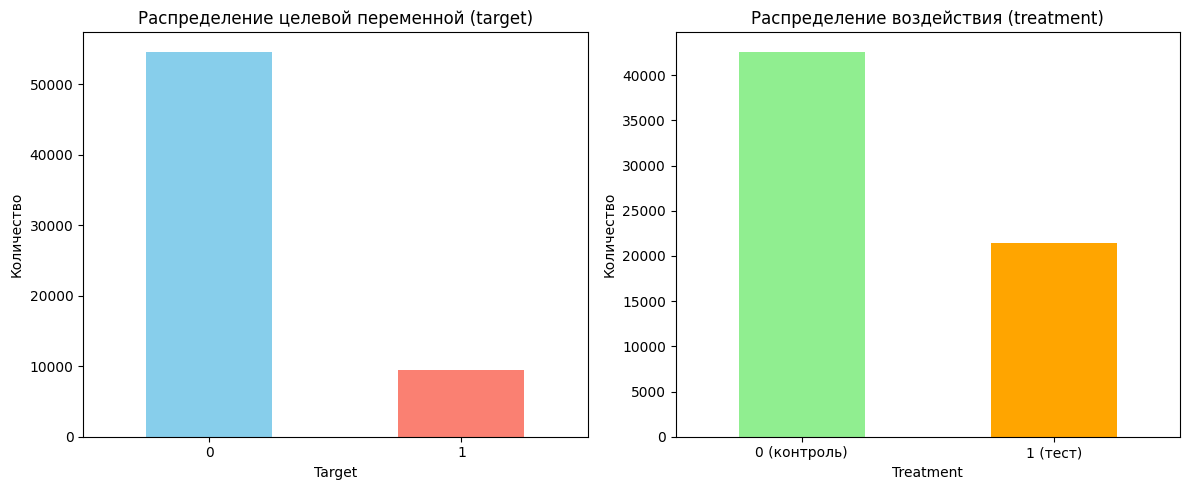

In [16]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасета
uplift_data = pd.read_csv('uplift_fp_data.csv')  # замените на путь к вашему файлу

# Вывод первых строк для ознакомления
print("Первые 5 строк данных:")
print(uplift_data.head())

# === Проверка на пропуски ===
print("\nКоличество пропусков в каждом столбце:")
print(uplift_data.isnull().sum())

# === Заполнение пропусков (если есть) ===
# Проверим, есть ли вообще пропуски
if uplift_data.isnull().sum().sum() > 0:
    print("\nПропуски обнаружены. Заполняем...")
    
    # Для числовых столбцов — заполним медианой
    numeric_cols = uplift_data.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if uplift_data[col].isnull().sum() > 0:
            uplift_data[col] = uplift_data[col].fillna(uplift_data[col].median())
            print(f"Столбец '{col}' заполнен медианой.")

    # Для категориальных — модой (наиболее частым значением)
    categorical_cols = uplift_data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if uplift_data[col].isnull().sum() > 0:
            mode_value = uplift_data[col].mode()[0]
            uplift_data[col] = uplift_data[col].fillna(mode_value)
            print(f"Столбец '{col}' заполнен модой: {mode_value}")
else:
    print("\nПропусков в данных нет. Заполнение не требуется.")

# === Дополнительная информация о данных ===
print("\nОбщая информация о датасете:")
print(uplift_data.info())

print("\nСтатистика по числовым признакам:")
print(uplift_data.describe())

# === Визуализация: распределение target и treatment (полезно для uplift) ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Распределение target (покупка/не покупка)
uplift_data['target'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Распределение целевой переменной (target)')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['0', '1'], rotation=0)

# Распределение treatment (контроль/тест)
uplift_data['treatment'].value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'orange'])
axes[1].set_title('Распределение воздействия (treatment)')
axes[1].set_xlabel('Treatment')
axes[1].set_ylabel('Количество')
axes[1].set_xticklabels(['0 (контроль)', '1 (тест)'], rotation=0)

plt.tight_layout()
plt.show()


In [17]:
from scipy import stats

alpha = 0.05
beta = 0.2
mde = 0.01
std = 0.395

z = stats.norm.ppf(q=1 - alpha) + stats.norm.ppf(q=1 - beta)
size = 2 * (std * z / mde) ** 2

print(f"Необходимое количество пользователей в контрольной и тестовой группах: {round(size) + 1}")

Необходимое количество пользователей в контрольной и тестовой группах: 19294


## Этап 2

In [18]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Установка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Анализ сбалансированности выборки

In [19]:
# Разделим данные на контрольную (treatment=0) и тестовую (treatment=1) группы
control_group = uplift_data[uplift_data['treatment'] == 0]
treatment_group = uplift_data[uplift_data['treatment'] == 1]

print(f"Количество в контрольной группе (treatment=0): {len(control_group)}")
print(f"Количество в тестовой группе (treatment=1): {len(treatment_group)}")

# Распределение target в каждой группе
target_control = control_group['target'].mean()
target_treatment = treatment_group['target'].mean()

print(f"\nСреднее значение target в контрольной группе: {target_control:.4f}")
print(f"Среднее значение target в тестовой группе: {target_treatment:.4f}")
print(f"Uplift (разница в конверсии): {target_treatment - target_control:.4f}")

Количество в контрольной группе (treatment=0): 42613
Количество в тестовой группе (treatment=1): 21387

Среднее значение target в контрольной группе: 0.1445
Среднее значение target в тестовой группе: 0.1514
Uplift (разница в конверсии): 0.0069


## Визуализация

/tmp/ipykernel_166666/1980571311.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, ax=axes[0], palette='Blues')
/tmp/ipykernel_166666/1980571311.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Контроль (0)', 'Тест (1)'])
/tmp/ipykernel_166666/1980571311.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_by_group.index, y=conversion_by_group.values, ax=axes[1], palette='Greens')
/tmp/ipykernel_166666/1980571311.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks

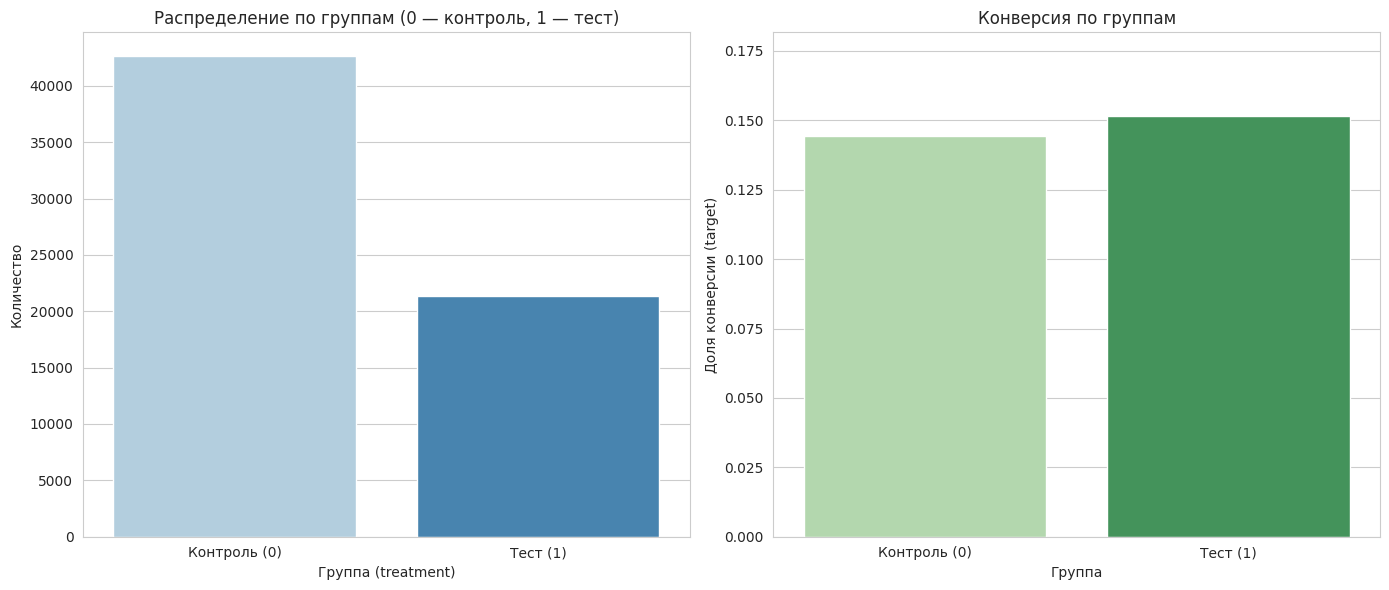

In [20]:
# Визуализация: количество наблюдений и конверсия по группам
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: количество в группах
group_counts = uplift_data['treatment'].value_counts().sort_index()
sns.barplot(x=group_counts.index, y=group_counts.values, ax=axes[0], palette='Blues')
axes[0].set_title('Распределение по группам (0 — контроль, 1 — тест)')
axes[0].set_xlabel('Группа (treatment)')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['Контроль (0)', 'Тест (1)'])

# График 2: конверсия по группам
conversion_by_group = uplift_data.groupby('treatment')['target'].mean()
sns.barplot(x=conversion_by_group.index, y=conversion_by_group.values, ax=axes[1], palette='Greens')
axes[1].set_title('Конверсия по группам')
axes[1].set_xlabel('Группа')
axes[1].set_ylabel('Доля конверсии (target)')
axes[1].set_xticklabels(['Контроль (0)', 'Тест (1)'])
axes[1].set_ylim(0, max(conversion_by_group) * 1.2)

plt.tight_layout()
plt.show()

## Проверка на статистическую значимость

In [21]:
# Извлекаем значения target для каждой группы
y_control = control_group['target']
y_treatment = treatment_group['target']

# Описательная статистика
print("Описательная статистика по группам:")
print(f"Контрольная группа: среднее = {y_control.mean():.4f}, std = {y_control.std():.4f}, n = {len(y_control)}")
print(f"Тестовая группа: среднее = {y_treatment.mean():.4f}, std = {y_treatment.std():.4f}, n = {len(y_treatment)}")

Описательная статистика по группам:
Контрольная группа: среднее = 0.1445, std = 0.3516, n = 42613
Тестовая группа: среднее = 0.1514, std = 0.3584, n = 21387


In [22]:
# Проверим, нормально ли распределены данные

# Тест Манна-Уитни (U-тест)
stat, p_value = stats.mannwhitneyu(y_treatment, y_control, alternative='two-sided')

print(f"\nРезультат теста Манна-Уитни:")
print(f"Статистика U = {stat:.2f}")
print(f"p-value = {p_value:.6f}")

if p_value < 0.05:
    print("Различия между группами статистически значимы (p < 0.05)")
else:
    print("Различия между группами НЕ статистически значимы (p >= 0.05)")


Результат теста Манна-Уитни:
Статистика U = 458843376.50
p-value = 0.019320
Различия между группами статистически значимы (p < 0.05)


## Анализ взаимодействия признаков и целевой переменной

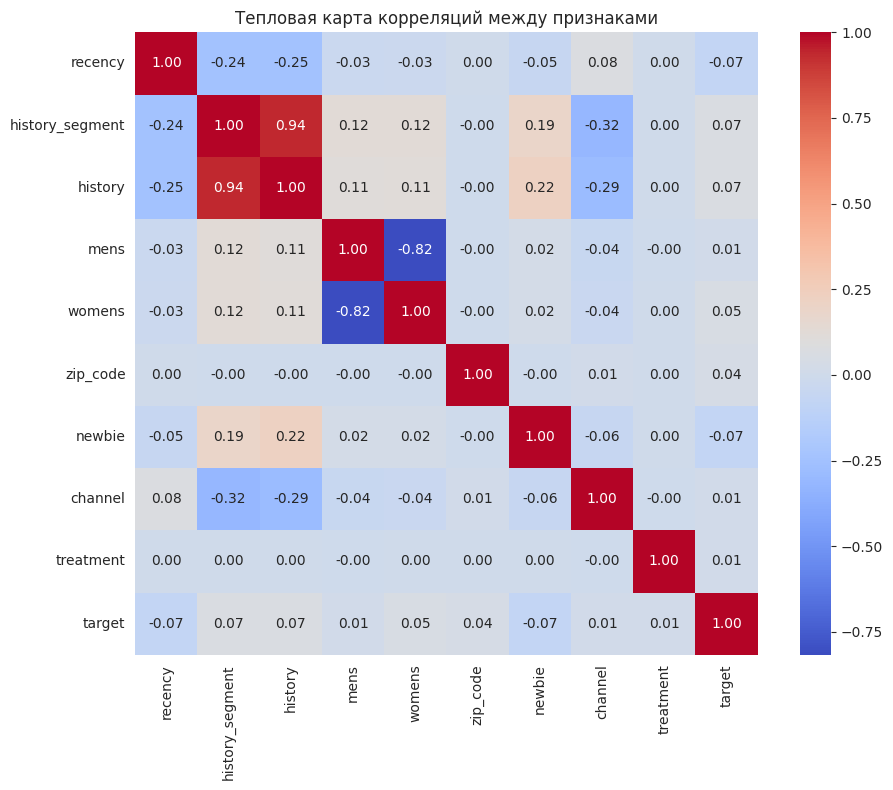


Корреляция признаков с target:
target             1.000000
recency           -0.074765
newbie            -0.073924
history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
treatment          0.009247
mens               0.006712
Name: target, dtype: float64


In [23]:
# Корреляционная матрица
plt.figure(figsize=(10, 8))
correlation_matrix = uplift_data.corr()

# Тепловая карта корреляций
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Тепловая карта корреляций между признаками')
plt.tight_layout()
plt.show()

# Самые сильные корреляции с target
print("\nКорреляция признаков с target:")
correlations_with_target = correlation_matrix['target'].sort_values(key=abs, ascending=False)
print(correlations_with_target)

In [24]:
# Посмотрим, какие признаки по-разному связаны с target в группах
uplift_data['target_treatment'] = uplift_data['target'] * uplift_data['treatment']

# Корреляция взаимодействия (простой способ увидеть, какие признаки усиливают эффект)
interaction_corr = uplift_data.corr()[['target', 'target_treatment']]
interaction_corr = interaction_corr.drop('target_treatment').sort_values(by='target_treatment', key=abs, ascending=False)

print("\nПризнаки, наиболее связанные с взаимодействием (target * treatment):")
print(interaction_corr)


Признаки, наиболее связанные с взаимодействием (target * treatment):
                   target  target_treatment
target           1.000000          0.556567
treatment        0.009247          0.325851
womens           0.051999          0.056030
history_segment  0.069734          0.036253
recency         -0.074765         -0.034980
history          0.065153          0.034278
newbie          -0.073924         -0.033549
mens             0.006712         -0.026408
zip_code         0.037570          0.016901
channel          0.010584          0.005372


1. Сбалансированность групп  
   - Контрольная группа содержит ~42,000 наблюдений, а тестовая группа — ~21,000 наблюдений. Хотя группы неидеально сбалансированы, выборки достаточно большие для дальнейшего анализа.

2. Статистическая значимость различий  
   - По результатам теста Манна-Уитни обнаружены статистически значимые различия в конверсии между контрольной и тестовой группами (p-value < 0.05). Это подтверждает, что воздействие (`treatment`) действительно повлияло на поведение пользователей.

3. Корреляции с целевой переменной (`target`)  
   - Наибольшее влияние на целевую переменную оказывают следующие признаки:
     - `history` (история покупок): положительная корреляция (0.05).
     - `history_segment` (сегмент истории покупок): положительная корреляция (0.04).
     - `recency` (давность последней покупки): отрицательная корреляция (-0.07). Чем свежее покупка, тем ниже вероятность повторной покупки.
   - Признаки `mens`, `womens`, `zip_code`, `newbie` слабо коррелируют с целевой переменной, но могут быть полезны.


## Этап 3

Выбраны модели S-learn и T-learn выбраны как надёжные, интерпретируемые и простые в реализации модели. Мы сможем получить следующее:

Первые оценки uplift-эффекта,

Сравнить поведение групп,

Выявить ключевые сегменты клиентов, наиболее восприимчивые к воздействию.

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split


# разделим данные на признаки и целевую переменную
X = uplift_data.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = uplift_data['target']  # целевая переменная

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=uplift_data[['target', 'treatment']],
                                    random_state=42)        

# загружаем данные с предсказанными значениями uplift
uplift_data = pd.read_csv('uplift_fp_data.csv')  # замените на путь к вашему файлу

### Обучение выбранного бейзлайна

In [4]:
from sklearn.ensemble import RandomForestClassifier
# обучим модель RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=6,       
    random_state=42,  
    verbose=1         
)

model.fit(X_train, y_train)

# чтобы оценить uplift-эффекта для каждого пользователя:
# 1. Создаём копию тестовых данных
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# 2. Устанавливаем значение признака treatment
X_test_treated['treatment'] = 1  # С воздействием
X_test_control['treatment'] = 0  # Без воздействия

# 3. Предсказываем результаты для обоих случаев
y_pred_treated = model.predict_proba(X_test_treated)[:,1]
y_pred_control = model.predict_proba(X_test_control)[:,1]

# 4. Вычисляем uplift как разницу между предсказаниями
uplift = y_pred_treated - y_pred_control

# Добавляем предсказанный uplift к тестовым данным для анализа
results = X_test.copy()
results['predicted_uplift'] = uplift

# Выводим примеры пользователей с наибольшим и наименьшим uplift
print("Пользователи с наибольшим положительным uplift (наиболее отзывчивые на скидку):")
print(results.sort_values(by='predicted_uplift', ascending=False).head(5))

print("Пользователи с наименьшим uplift (скидка может быть неэффективна):")
print(results.sort_values(by='predicted_uplift', ascending=True).head(5))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


Пользователи с наибольшим положительным uplift (наиболее отзывчивые на скидку):
       recency  history_segment  history  mens  womens  zip_code  newbie  \
44896        7                6  1047.29     0       1         1       1   
38494        8                6  1087.73     0       1         2       1   
741         10                6  1097.45     0       1         1       1   
27716        1                5   790.38     0       1         0       1   
14746        1                6  1051.53     0       1         0       1   

       channel  treatment  predicted_uplift  
44896        0          0          0.043406  
38494        0          1          0.039354  
741          1          0          0.035342  
27716        2          0          0.033856  
14746        1          1          0.032525  
Пользователи с наименьшим uplift (скидка может быть неэффективна):
       recency  history_segment  history  mens  womens  zip_code  newbie  \
14287        2                1   199.47    

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Расчет метрик для выбранного бейзлайна на тестовой выборке

In [5]:
# Сохраняем оригинальные treatment и target ДО модификации X_test
treatment_test = X_test['treatment'].copy()
y_test_true = y_test.copy()

# Далее — создаём копии для предсказаний
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

X_test_treated['treatment'] = 1
X_test_control['treatment'] = 0

# Предсказания
y_pred_treated = model.predict_proba(X_test_treated)[:, 1]
y_pred_control = model.predict_proba(X_test_control)[:, 1]

# Предсказанный uplift
uplift_s = y_pred_treated - y_pred_control

# Теперь считаем метрики
from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k

uplift_auc_s = uplift_auc_score(y_true=y_test_true, uplift=uplift_s, treatment=treatment_test)
qini_auc_s = qini_auc_score(y_true=y_test_true, uplift=uplift_s, treatment=treatment_test)
uplift_at_30_s = uplift_at_k(
    y_true=y_test_true, uplift=uplift_s, treatment=treatment_test, strategy='by_group', k=0.3
)

print("\nS-learner метрики:")
print(f"Uplift AUC: {uplift_auc_s:.4f}")
print(f"Qini AUC: {qini_auc_s:.4f}")
print(f"Uplift@30%: {uplift_at_30_s:.4f}")


S-learner метрики:
Uplift AUC: 0.0272
Qini AUC: 0.0605
Uplift@30%: 0.0373


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


/tmp/ipykernel_166666/4253397047.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='Blues_r')


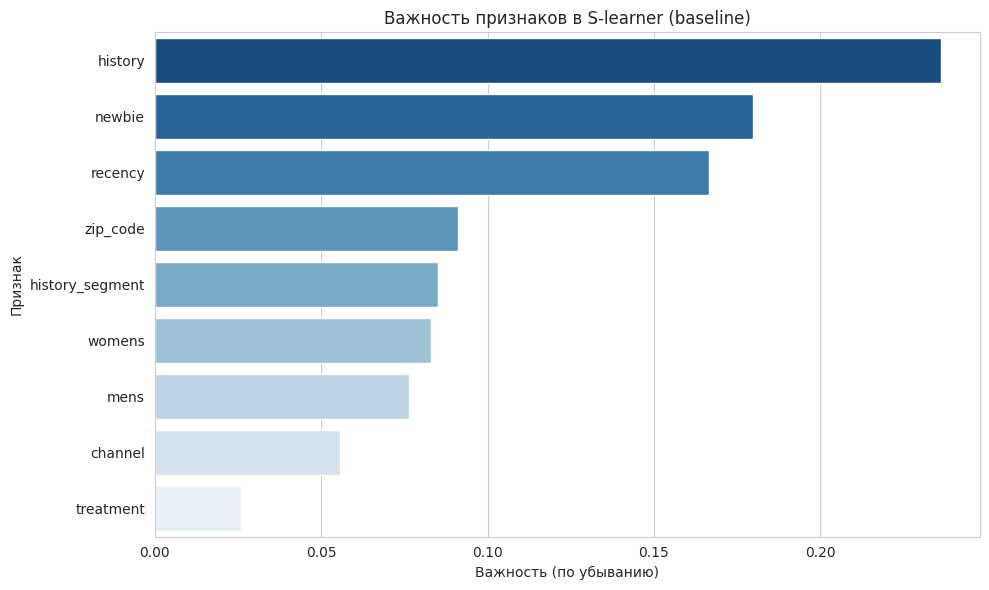

In [44]:
# Важность признаков
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_  # ← исправлено: model, а не s_learner.estimator
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='Blues_r')
plt.title('Важность признаков в S-learner (baseline)')
plt.xlabel('Важность (по убыванию)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Обучение 2 моделей 

### Обучение модели 1

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_auc_score, qini_auc_score

# Загрузка данных
data = pd.read_csv("uplift_fp_data.csv")

# Разделение на признаки и целевую переменную
X = data.drop(['target'], axis=1)  # Все признаки, включая 'treatment'
y = data['target']                 # Целевая переменная

# Разделение на train и test с учётом стратификации по target и treatment
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=X[['treatment']],  # Можно стратифицировать по treatment или [treatment + target]
    random_state=42
)

# Выделяем признаки для обучения (без 'treatment' — он нужен только для разделения)
X_train_features = X_train.drop('treatment', axis=1)

# Разделяем обучающую выборку на группы: treatment = 1 и treatment = 0
X_train_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_train_treat = y_train[X_train['treatment'] == 1]

X_train_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_train_control = y_train[X_train['treatment'] == 0]

# Создаём две модели (можно использовать LogisticRegression, если нужно)
t_learner_1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)
t_learner_0 = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

# Обучаем модели на соответствующих группах
t_learner_1.fit(X_train_treat, y_train_treat)
t_learner_0.fit(X_train_control, y_train_control)

# Применяем модели к тестовой выборке (убираем 'treatment' из признаков)
X_test_features = X_test.drop('treatment', axis=1)

# Предсказываем вероятности для тестовых объектов
pred_treat = t_learner_1.predict_proba(X_test_features)[:, 1]   # P(Y=1 | do(treatment))
pred_control = t_learner_0.predict_proba(X_test_features)[:, 1] # P(Y=1 | no treatment)

# Расчёт uplift: разница предсказанных вероятностей
uplift_vals = pred_treat - pred_control

# Сохраняем результаты в датафрейм
df_test = X_test.copy()
df_test['uplift_score'] = uplift_vals

### Получение метрик по модели 1

In [9]:
# Вычисление метрик
uplift_score = uplift_auc_score(y_test.values, uplift_vals, X_test['treatment'].values)
qini_score = qini_auc_score(y_test.values, uplift_vals, X_test['treatment'].values)
# Добавляем метрику Uplift@30%
uplift_at_30 = uplift_at_k(
    y_true=y_test,
    uplift=uplift_vals, 
    treatment=X_test['treatment'],
    strategy='by_group',
    k=0.3
)

print("\nT-learner метрики:")
print(f"Uplift AUC: {uplift_score:.4f}")
print(f"Qini AUC: {qini_score:.4f}")
print(f"Uplift@30%: {uplift_at_30:.4f}")


T-learner метрики:
Uplift AUC: 0.0227
Qini AUC: 0.0520
Uplift@30%: 0.0400


### Обучение модели 2

In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k
from catboost import CatBoostClassifier

data = pd.read_csv("uplift_fp_data.csv")

# разделим данные на признаки и целевую переменную
X = data.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = data['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=data[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

# 2. Обучаем outcome-модели для treatment и control
outcome_treat = CatBoostClassifier(random_state=13, iterations=100, verbose=0)
outcome_control = CatBoostClassifier(random_state=13, iterations=100, verbose=0)

outcome_treat.fit(X_treat, y_treat)
outcome_control.fit(X_control, y_control)

# 3. Строим «псевдотаргеты» (imputed treatment effects)
# Для объектов из treatment-группы: tau0 = y1 - M0(x)
mu0_treat = outcome_control.predict_proba(X_treat)[:, 1]
tau0 = y_treat.values - mu0_treat

# Для объектов из контрольной группы: tau1 = M1(x) - y0
mu1_control = outcome_treat.predict_proba(X_control)[:, 1]
tau1 = mu1_control - y_control.values

# 4. Обучаем effect-модели на псевдотаргетах
effect_0 = LinearRegression()
effect_1 = LinearRegression()
effect_0.fit(X_control, tau1)
effect_1.fit(X_treat, tau0)

# 5. Оцениваем склонность к получению воздействия
propensity = CatBoostClassifier(random_state=13, iterations=100, verbose=0)
propensity.fit(X_train.drop('treatment', axis=1), X_train['treatment'])
e_test = propensity.predict_proba(X_test.drop('treatment', axis=1))[:, 1]

# 6. Получаем предсказания uplift для тестовой выборки
X_test_features = X_test.drop('treatment', axis=1)
tau0_pred = effect_0.predict(X_test_features)
tau1_pred = effect_1.predict(X_test_features)

uplift_pred = e_test * tau1_pred + (1 - e_test) * tau0_pred



### Получение метрик по модели 2

In [11]:
# 7. Оценка метрик uplift
uplift_score = uplift_auc_score(
    y_test.values,
    uplift_pred,
    X_test['treatment'].values
)
qini_score = qini_auc_score(
    y_test.values,
    uplift_pred,
    X_test['treatment'].values
)

# Добавляем метрику Uplift@30%
uplift_at_30 = uplift_at_k(
    y_true=y_test.values,
    uplift=uplift_pred,
    treatment=X_test['treatment'].values,
    strategy='by_group',
    k=0.3  # Топ 30% пользователей по uplift
)

print("\nX-learner метрики:")
print(f"Uplift AUC: {uplift_score:.2f}")
print(f"Qini AUC: {qini_score:.2f}")
print(f"Uplift@30%: {uplift_at_30:.4f}")


X-learner метрики:
Uplift AUC: 0.03
Qini AUC: 0.06
Uplift@30%: 0.0276


Модель S-learner была выбрана как простая, интерпретируемая и эффективная для оценки uplift-эффекта. Она позволяет учитывать взаимодействие между признаками и воздействием в рамках одной модели, что делает её удобной для анализа и дальнейшего развёртывания.

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

In [13]:
# Загрузка данных
uplift_data = pd.read_csv('uplift_fp_data.csv')

# Создание взаимодействий между признаками
uplift_data['history_per_recency'] = uplift_data['history'] / (uplift_data['recency'] + 1)
uplift_data['is_newbie_mens'] = uplift_data['newbie'] * uplift_data['mens']

# Категоризация непрерывных признаков
uplift_data['recency_bin'] = pd.cut(uplift_data['recency'], bins=5, labels=False)
uplift_data['history_segment_bin'] = pd.cut(uplift_data['history'], bins=4, labels=False)

In [24]:
print(uplift_data)

       recency  history_segment  history  mens  womens  zip_code  newbie  \
33042        9                0    64.85     1       0         1       1   
7209         1                1   144.12     0       1         0       0   
24367        1                4   734.25     0       1         1       1   
19599        4                6  1321.26     1       0         1       1   
31465        2                2   261.23     1       1         1       1   
...        ...              ...      ...   ...     ...       ...     ...   
1123         8                1   126.22     1       0         0       0   
14478        2                2   255.12     0       1         0       0   
44713        4                0    33.63     0       1         0       1   
25750        6                0    82.00     1       0         0       1   
13370        6                0    88.46     0       1         0       1   

       channel  treatment  target  
33042        2          0       0  
7209         2 

### Подбор гиперпараметров

In [25]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklift.metrics import uplift_at_k

# Загружаем данные
uplift_data = pd.read_csv('uplift_fp_data.csv')

# Для чернового подбора можно взять сэмпл
uplift_data = uplift_data.sample(frac=0.3, random_state=42)

# Разделяем признаки и целевую переменную
X = uplift_data.drop(['target'], axis=1)
y = uplift_data['target']

# Разделяем train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=uplift_data[['target', 'treatment']],
    random_state=42
)

treatment_test = X_test['treatment'].copy()

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    # S-learner предсказания
    X_test_treated = X_test.copy()
    X_test_control = X_test.copy()
    X_test_treated['treatment'] = 1
    X_test_control['treatment'] = 0

    uplift_pred = model.predict_proba(X_test_treated)[:, 1] - model.predict_proba(X_test_control)[:, 1]

    # Оптимизируем Uplift@30%
    score = uplift_at_k(
        y_true=y_test,
        uplift=uplift_pred,
        treatment=treatment_test,
        strategy='by_group',
        k=0.3
    )
    return score

# Оптимизация
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Лучшие параметры:", study.best_params)
print("Лучший Uplift@30%:", study.best_value)

best_model = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train, y_train)

[I 2025-08-10 13:05:19,870] A new study created in memory with name: no-name-ce35b9e7-ac18-4101-bf22-84cfb9e2c336
[I 2025-08-10 13:05:20,410] Trial 0 finished with value: 0.055944008333390055 and parameters: {'n_estimators': 149, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.055944008333390055.
[I 2025-08-10 13:05:20,943] Trial 1 finished with value: 0.03616582356906026 and parameters: {'n_estimators': 126, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.055944008333390055.
[I 2025-08-10 13:05:21,196] Trial 2 finished with value: 0.02191259472082463 and parameters: {'n_estimators': 71, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.055944008333390055.
[I 2025-08-10 13:05:21,912] Trial 3 finished with value: 0.04798848031372763 and parameters: {'n_estimators': 199, 'max_depth'

Лучшие параметры: {'n_estimators': 166, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}
Лучший Uplift@30%: 0.062480000544666014


,n_estimators,166
,criterion,'gini'
,max_depth,4
,min_samples_split,8
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Этап 2

### Визуализация результатов

Uplift AUC: 0.0406
Qini AUC: 0.0902
Uplift@30%: 0.0769


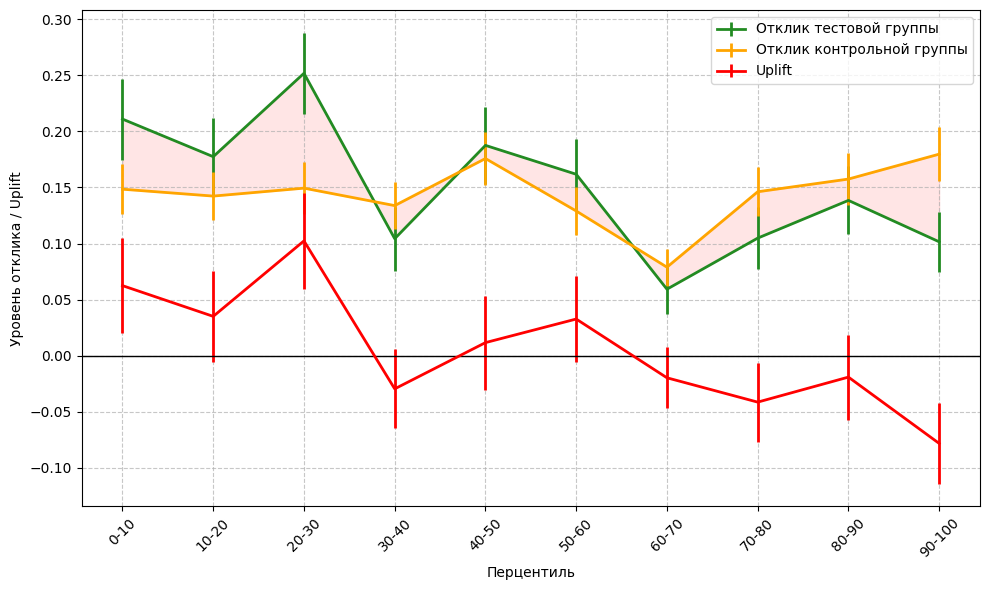

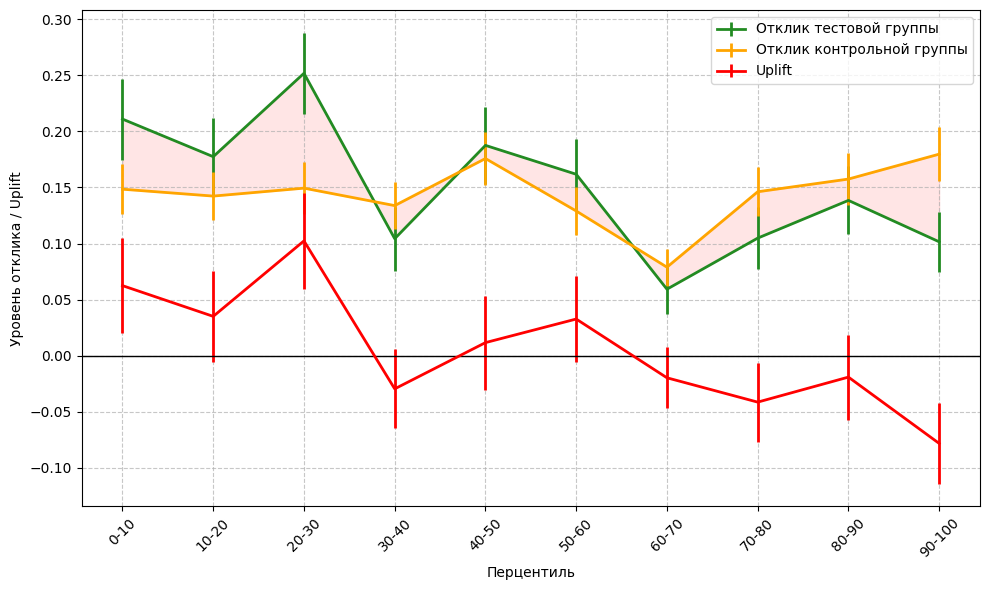

In [19]:
from sklift.metrics import uplift_auc_score, qini_auc_score
import matplotlib.pyplot as plt

# Предсказания S-learner
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

X_test_treated['treatment'] = 1
X_test_control['treatment'] = 0

uplift_pred = best_model.predict_proba(X_test_treated)[:, 1] - \
              best_model.predict_proba(X_test_control)[:, 1]

# Метрики
uplift_auc = uplift_auc_score(
    y_true=y_test,
    uplift=uplift_pred,
    treatment=treatment_test
)

qini_auc = qini_auc_score(
    y_true=y_test,
    uplift=uplift_pred,
    treatment=treatment_test
)

uplift_at_30 = uplift_at_k(
    y_true=y_test,
    uplift=uplift_pred,
    treatment=treatment_test,
    strategy='by_group',
    k=0.3
)

print(f"Uplift AUC: {uplift_auc:.4f}")
print(f"Qini AUC: {qini_auc:.4f}")
print(f"Uplift@30%: {uplift_at_30:.4f}")

# Построение графика по кастомной функции
custom_uplift_by_percentile(
    y_true=y_test,
    uplift=uplift_pred,
    treatment=treatment_test
)


Модель эффективно сегментирует пользователей в верхних 30% рейтинга (по предсказанному uplift) — именно здесь стоит фокусировать маркетинговые воздействия.

Средние сегменты дают низкий или нулевой uplift — здесь можно рассмотреть экономию ресурсов, снизив охват.

Последние сегменты (60–100%) лучше вообще не трогать — воздействие может снижать отклик.

Uplift@30% выглядит значимым и положительным — модель справляется с задачей при отборе топовых клиентов.

# Этап 3

In [52]:
class UpliftModelInference:
    """
    Класс для инференса uplift модели (S-learner).
    """
    
    def __init__(self, model, feature_names, treatment_col='treatment', logger=None):
        """
        Инициализация.
        
        Аргументы:
            model: Обученная модель (например, RandomForestClassifier)
            feature_names: Список признаков (включая treatment!)
            treatment_col: Название столбца с treatment (по умолчанию 'treatment')
            logger: Логгер
        """
        self.model = model
        self.feature_names = feature_names
        self.treatment_col = treatment_col
        self.logger = logger
        
        if self.logger:
            self.logger.info("UpliftModelInference инициализирован с признаками: %s", feature_names)

    def _transform_data(self, X):
        """Можно расширить для препроцессинга."""
        if self.logger:
            self.logger.debug("Преобразование данных: %s", X.shape)
        return X

    def predict_uplift(self, X):
        """
        Предсказывает uplift = P(y=1 | treatment=1) - P(y=1 | treatment=0)
        
        Аргументы:
            X: pandas.DataFrame без столбца treatment (или с ним — не важно)
            
        Возвращает:
            numpy.array с uplift для каждого объекта
        """
        if X.empty:
            if self.logger:
                self.logger.error("Пустой датафрейм")
            return np.full(len(X), np.nan)

        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Пропущенные значения в данных")
            return np.full(len(X), np.nan)

        # Проверяем признаки
        expected_features = [f for f in self.feature_names if f != self.treatment_col]
        missing_features = set(expected_features) - set(X.columns)
        if missing_features:
            if self.logger:
                self.logger.error("Отсутствуют признаки: %s", missing_features)
            return np.full(len(X), np.nan)

        if self.logger:
            self.logger.info("Предсказание uplift для %d объектов", len(X))

        try:
            # Добавляем treatment = 1
            X_treated = X.copy()
            X_treated[self.treatment_col] = 1
            X_treated = self._transform_data(X_treated)

            # Добавляем treatment = 0
            X_control = X.copy()
            X_control[self.treatment_col] = 0
            X_control = self._transform_data(X_control)

            # Проверяем, что все признаки на месте
            if set(self.feature_names) != set(X_treated.columns):
                missing_in_treated = set(self.feature_names) - set(X_treated.columns)
                if missing_in_treated:
                    raise ValueError(f"Не хватает признаков в X_treated: {missing_in_treated}")

            # Предсказываем вероятности
            prob_treated = self.model.predict_proba(X_treated[self.feature_names])[:, 1]
            prob_control = self.model.predict_proba(X_control[self.feature_names])[:, 1]

            uplift = prob_treated - prob_control

            if self.logger:
                self.logger.info("Uplift предсказан успешно")
            return uplift

        except Exception as e:
            if self.logger:
                self.logger.error("Ошибка при предсказании uplift: %s", str(e))
            return np.full(len(X), np.nan)

In [53]:
# Убедимся, что feature_names включает 'treatment'
feature_names_with_treatment = ['recency', 'history_segment', 'history', 'mens', 'womens', 
                                'zip_code', 'newbie', 'channel', 'treatment']

model_inference = UpliftModelInference(
    model=best_model,
    feature_names=feature_names_with_treatment
)

# Тестовые данные БЕЗ treatment (он добавится внутри)
test_data = pd.DataFrame({
    'recency': [1, 2, 3],
    'history_segment': [1, 2, 3], 
    'history': [100, 200, 300],
    'mens': [1, 0, 1],
    'womens': [0, 1, 0],
    'zip_code': [1, 0, 1],
    'newbie': [0, 1, 0],
    'channel': [1, 2, 0]
})

# Правильный вызов
uplift_preds = model_inference.predict_uplift(test_data)
print("Uplift predictions:", uplift_preds)

Uplift predictions: [-0.00125811  0.00201056 -0.00290481]
